In [ ]:
## Importing the libraries:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  #attach your Google drive to read write file
  drive.mount('/content/drive')
  rootdir = '/content/drive/My Drive/Colab Notebooks/'
else:
  rootdir = '../'
  
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

In [ ]:
rootdir = '/content/drive/My Drive/Colab Notebooks/'

In [3]:
%load $rootdir/

/content/drive/My Drive/Colab Notebooks/


#Multiple choice challenges
1. Consider a dice with a property that the probability of a face with n dots showing up is proportional to n. The probability of face showing 4 dots is? Why? \
a)   1/7  \
b)   5/42 \
c)   1/21 \
d)   4/21 \


2. The difference between the sample value expected and the estimates value of the parameter is called as? Could you explain the meaning of the other terminologies? \
a) bias \
b) error \
c) contradiction \
d) difference \








#Code and Data analysis challenges

If you have time, explore data and show your data analysis skill on top of providing answer to the two challenges posted below. 

In [ ]:
def print_full(x):
  '''
  This is to print nicely DataFrame wide tables
  '''
  pd.set_option('display.max_rows', len(x))
  pd.set_option('display.max_columns', None)
  pd.set_option('display.width', 2000)
  pd.set_option('display.float_format', '{:20,.2f}'.format)
  pd.set_option('display.max_colwidth', -1)
  print(x)
  pd.reset_option('display.max_rows')
  pd.reset_option('display.max_columns')
  pd.reset_option('display.width')
  pd.reset_option('display.float_format')
  pd.reset_option('display.max_colwidth')

def agegrp_func(x):
  '''
  Function to format how age group is presented
  WHO uses AGE20-30, we want just 20-30
  '''
  if 'AGELT1' in x:
    y = '0-1'
  elif 'AGE85' in x:
    y = '85+'
  else:
    y=x.replace('AGE','')

  return y

def agegrp_mid(x):
  '''
  Function to calculate the mid age of an age group
  '''
  if 'AGELT1' in x:
    y = -3
  elif 'AGE85' in x:
    y = 87
  else:
    try:
      y=int(np.mean([int(i) for i in x.replace('AGE','').split('-')]))
    except:
      y = int(x.replace('AGE','').split('-')[0])
  return y  

class whoapi():
  '''
  This class defines methods to get data from World Health Organisation (WHO) API
  The different WHO health and related data is structured by country and indicator id (ids) 
  For example 
    Country = ETH
    indicatorid='LIFE_0000000029' 
  describes the probability of dying in age groups for Ethiopia
  Reference: for more information about available WHO data, refer
  https://www.who.int/data/gho  
  '''
  def __init__(self, dim='GHO',**kwargs):
    #
    self.url = f"http://apps.who.int/gho/athena/api/{dim}"
    self.verbose = kwargs.get('verbose',0)

  @staticmethod
  def age_sex_stem(df):    
    '''
    To nicely format AGE and SEX columns
    '''
    if 'AGEGROUP' in df.columns:
      df['MidAge'] = df['AGEGROUP'].map(agegrp_mid)
      df['AGEGROUP'] = df['AGEGROUP'].map(agegrp_func)       
      df = df.sort_values('MidAge').reset_index().drop(columns=['index'])
      
    if 'SEX' in df.columns:
      df['SEX'] = df['SEX'].map(lambda x:{'MLE':'Male',
                                              'FMLE':'Female',
                                              'BTSX':'Both'}.get(x,x))
    return df    

  def get_ids(self,s):
    df = self.dfid

    name = s
    if isinstance(s,str):
      name = [s]    

    dflist = [] 
    for d in name:
      dflist.append(df[df['id'].map(lambda x : d in x)])

    #try:
    df = pd.concat(dflist)
    #except:
    #  df = pd.DataFrame()

    return df

  def get_gho_data(self, id, fdict=None, 
                   url=None,verbose=None):
    '''
    given 
      id: indicator id, 
      fdict: dictionary of filters e.g {'COUNTRY':ETH,'YEAR':2016} ethiopian data from 2016
      url (optional)
      verbose: feedback level (0 -  less info to print; >=2 debug mode)
    get data from WHO server and return it as pandas DataFrame 
    '''
    #
    verbose = self.verbose if verbose is None else verbose
    #
    ids = id
    if isinstance(id,list):
      ids = ','.join(id)

    if url is None:
      url = f"{self.url}/{ids}.csv"

    if verbose>1:
      print('API url:',url)

    if not fdict is None:
      url += '?filter=' + ";".join([f"{k}:{v}" for k, v in fdict.items()])
    
    df = pd.read_csv(url)
    df = df.dropna(axis=1, how='all')
    try:
      df = df.drop(columns=['Comments'])
      df = df.drop(columns=['Comments'])
    except:
      #print('not dropping Comments')
      pass

    return df

  def country_data(self,ids,countries=['ETH'],year=2016):    
    '''
    This is a wrapper to 
      method: get_gho_data 
    This method allows one easily to pass multiple countries in a list
    '''
    if isinstance(countries,str):
      countries = [countries]

    dflist = []
    verbose=self.verbose
    for c in countries:
      print(f'processing country={c}')
      df = self.get_gho_data(ids,fdict={'COUNTRY':c,'YEAR':year},verbose=verbose)
      print(df.shape)
      verbose += 2
      dflist.append(df)

    df = pd.concat(dflist)
    print('all_df.shape',df.shape)
    return df

  def death_rates(self,**kwargs):
    '''
    This method fetchs data for the death rate from WHO server. 
    if a list of countries in their iso-3 code (e.g ITH, ETH, USA..) passed
    using keyword 
      countries=[ITH, ETH, USA], 
    The data will be returned only to these countries
    '''
    name = 'LIFE_0000000029'
    try:
      return self.age_sex_stem(self.country_data(name,**kwargs))
    except:
      return self.country_data(name,**kwargs)

  def dying_prob(self,**kwargs):
    '''
    This method fetchs the probability of dying data at a given age from WHO serer  
    if a list of countries in their iso-3 code (e.g ITH, ETH, USA..) passed
    using keyword 
      countries=[ITH, ETH, USA], 
    The data will be returned only to these countries
    '''

    name = 'LIFE_0000000030'
    df = self.country_data(name,**kwargs)
    try:
      return self.age_sex_stem(df)
    except:
      raise
      return df                

##Challenge 1
Below we use the `whoapi` class defined above to fetch data as pandas dataframe. The following plot is produced using the data stored in `df_pd` variable defined in the next cell. 

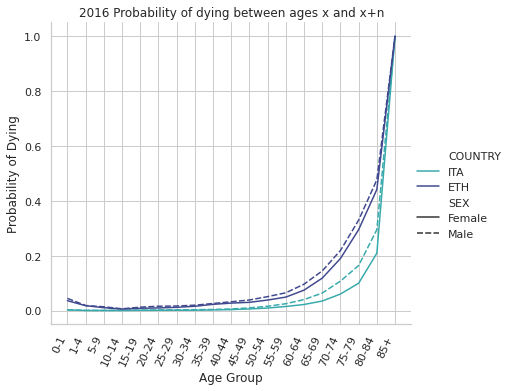


#### **Your task is to make a plot similar to this plot. You may use different colors, but the x axis labels should be rotated to make it look nice and readable. The over all quality of the plot should be as good or better than this plot. We used something like the following to the above plot**
```python
sns.set_style("ticks", {"xtick.major": len(xticks)})
with sns.axes_style("whitegrid"):
  chart = sns.relplot()
```
 
You can change the countries if you like e.g. compare your country with other contries.

In [ ]:
#initiate the whoapi class
hapi = whoapi()

#get data for dying probabilty of countries
df_pd = hapi.dying_prob(countries=["ETH","ITA"])

#plot data
print('dying prob df.shape',df_pd.shape)
xtickslabel = df_pd['AGEGROUP'].unique()
xticks = df_pd['MidAge'].unique()

processing country=ETH
(38, 9)
processing country=ITA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
all_df.shape (76, 9)
dying prob df.shape (76, 10)


##Challenge 2

Plot death rates as a function of age by calling the `death_rate` method. You can either use your choice of countries or use `countries=['ETH','ITA']`.